## Problem Statement 
- The goal of this project is to detect anomalies in time-series sensor data collected from industrial equipment. These anomalies may indicate early signs of equipment failure or the need for maintenance.

In [2]:
import os
import pandas as pd
import numpy as np 

### Dataset Used:
 NASA Bearing Dataset
#### Reason for Selection:
- Contains real vibration sensor data from rotating machinery
- Closely represents industrial IoT sensor data

In [3]:
DATA_PATH = r"data/1st_test" 

In [4]:
files = sorted(os.listdir(DATA_PATH))
files[:5] 


['2003.10.22.12.06.24',
 '2003.10.22.12.09.13',
 '2003.10.22.12.14.13',
 '2003.10.22.12.19.13',
 '2003.10.22.12.24.13']

##### Data Preparation & Cleaning
 Steps Performed:

- Loaded raw sensor files from the dataset folder
- Sorted files chronologically using filenames
- Read each file as numerical sensor data
- Verified data consistency and numeric format 

file_path = os.path.join(DATA_PATH, files[0])

sample = pd.read_csv(file_path, sep=r"\s+", header=None)
sample.head()


In [65]:
print(len(files))

2156


### Feature Engineering

- Raw sensor signals contain thousands of data points per file and are not directly suitable for machine learning models.

Extracted Features per Time Window:
- Mean: average vibration level
- Standard Deviation (STD): variability in vibration
- RMS (Root Mean Square): vibration energy
- Maximum value: peak vibration
### Scaling:

- Features Scaling (standardizer)
- This ensures equal importance across all features

In [9]:
rows = []

for i, file in enumerate(files):
    path = os.path.join(DATA_PATH, file)
    data = pd.read_csv(path, sep=r"\s+", header=None)
    
    row = {
        "time_index": i,
        "mean": data.mean().mean(),
        "std": data.std().mean(),
        "rms": np.sqrt((data**2).mean().mean()),
        "max": data.max().max()
    }
    
    rows.append(row)

df = pd.DataFrame(rows)
df.head()


,time_index,mean,std,rms,max
0,0,-0.092867,0.079169,0.122632,0.701
1,1,-0.092818,0.078292,0.122069,0.581
2,2,-0.094864,0.078514,0.123737,0.549
3,3,-0.094414,0.079252,0.123883,0.535
4,4,-0.094372,0.078952,0.123623,0.471


In [10]:
df.shape


(2156, 5)

### 5. Exploratory Data Analysis (EDA)
- Understand sensor behavior over time
- Identify trends and instability
- Visually inspect degradation patterns

### Key Observation:
- Standard deviation and RMS increase over time
- Indicates increasing vibration and bearing wear
- Confirms expected mechanical degradation behavior
- EDA helps establish what “normal” and “abnormal” behavior looks like.

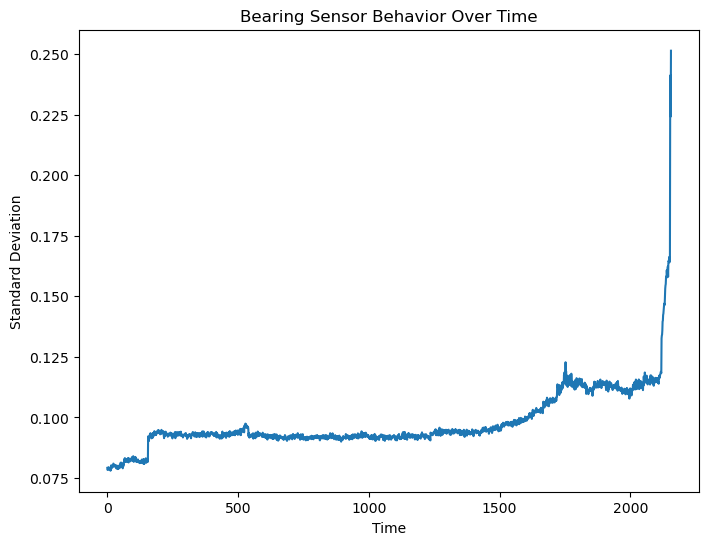

In [11]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))
plt.plot(df["time_index"], df["std"])
plt.xlabel("Time")
plt.ylabel("Standard Deviation")
plt.title("Bearing Sensor Behavior Over Time")
plt.show()


### feature scaling done by standardization 

In [13]:
from sklearn.preprocessing import StandardScaler

X = df.drop(columns=["time_index"])
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
 

### Model 1  Isolation Forest 

#### Why Isolation Forest:
- Unsupervised method (no labels required)
- Effective for detecting rare and abnormal points
- Widely used for anomaly detection in sensor data

#### Working Principle:
-Isolation Forest isolates data points by randomly splitting the feature space. Points that are isolated quickly are considered anomalies.

Output: 
- 0 → Normal
- 1 → Anomaly

In [15]:
from sklearn.ensemble import IsolationForest

iso = IsolationForest(
    n_estimators=100,
    contamination=0.05,
    random_state=42
)

df["anomaly_iforest"] = iso.fit_predict(X_scaled)
df["anomaly_iforest"] = df["anomaly_iforest"].map({1: 0, -1: 1})


### Visualize Isolation Forest Anomalies

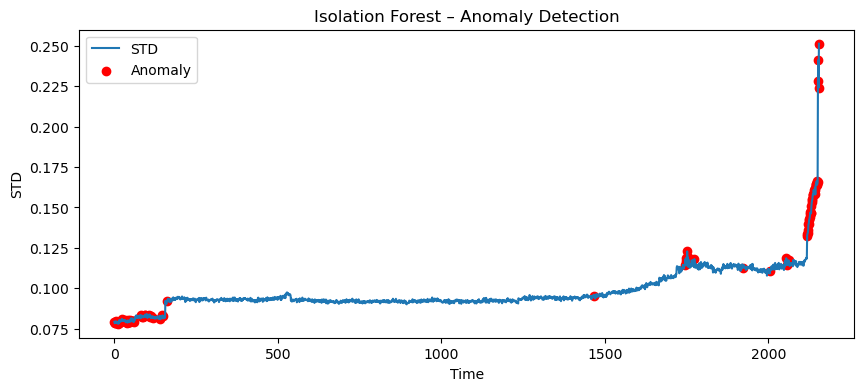

In [17]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,4))
plt.plot(df["time_index"], df["std"], label="STD")
plt.scatter(
    df[df["anomaly_iforest"] == 1]["time_index"],
    df[df["anomaly_iforest"] == 1]["std"],
    color="red",
    label="Anomaly"
)
plt.xlabel("Time")
plt.ylabel("STD")
plt.title("Isolation Forest – Anomaly Detection")
plt.legend()
plt.show()


#### Isolation Forest isolates rare and unusual sensor patterns by randomly partitioning the feature space. Sensor windows that are easier to isolate are classified as anomalies.”

### Model 2 - AutoEncoder 

Why Autoencoder:

- Learns normal behavior from data
- Reconstruction error highlights anomalies
- Suitable for continuous sensor monitoring

In [20]:
train_size = int(0.6 * len(X_scaled))
X_train = X_scaled[:train_size]
X_test = X_scaled


In [39]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input

model = Sequential([
    Input(shape=(X_train.shape[1],)),
    Dense(16, activation="relu"),
    Dense(8, activation="relu"),
    Dense(16, activation="relu"),
    Dense(X_train.shape[1], activation="linear")
])

model.compile(optimizer="adam", loss="mse")


### training the model

In [42]:
model.fit(
    X_train, X_train,
    epochs=30,
    batch_size=32,
    validation_split=0.1,
    verbose=1
)


Epoch 1/30
37/37 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.3094 - val_loss: 0.0514
Epoch 2/30
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1375 - val_loss: 0.0323
Epoch 3/30
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0584 - val_loss: 0.0194
Epoch 4/30
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0215 - val_loss: 0.0116
Epoch 5/30
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0091 - val_loss: 0.0075
Epoch 6/30
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0061 - val_loss: 0.0051
Epoch 7/30
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0047 - val_loss: 0.0034
Epoch 8/30
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0034 - val_loss: 0.0024
Epoch 9/30
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0026 - val_loss: 0.0019
Epoch 10/30
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0021 - val_loss: 0.0016
Epoch 11/30
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0019 - val_loss: 0.0015
Epoch 12/30
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0016 - val_lo

#### Detect anomalies using reconstruction error

In [45]:
reconstructions = model.predict(X_test)
reconstruction_error = ((X_test - reconstructions) ** 2).mean(axis=1)

threshold = np.percentile(reconstruction_error, 95)
df["anomaly_autoencoder"] = (reconstruction_error > threshold).astype(int)


68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


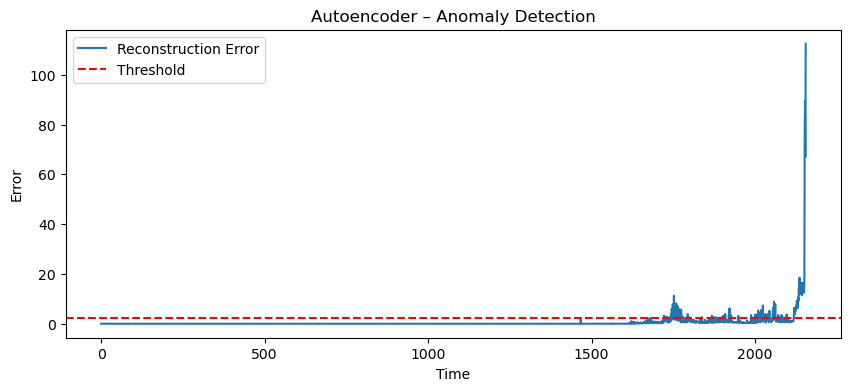

In [47]:
plt.figure(figsize=(10,4))
plt.plot(df["time_index"], reconstruction_error, label="Reconstruction Error")
plt.axhline(threshold, color="red", linestyle="--", label="Threshold")
plt.xlabel("Time")
plt.ylabel("Error")
plt.title("Autoencoder – Anomaly Detection")
plt.legend()
plt.show()


### Model Evaluation & Validation

Challenge:

- No labeled anomalies available
- Traditional supervised evaluation metrics like accuracy, precision, recall, and F1-score could not be directly calculated because there were no anomaly labels.

Evaluation Approach Used:

- Visual inspection of anomalies over time

- Domain reasoning based on bearing degradation

- Cross-model agreement between Isolation Forest and Autoencoder 



In [54]:
# just comparing both the models.
df[["anomaly_iforest", "anomaly_autoencoder"]].value_counts()

anomaly_iforest  anomaly_autoencoder
0                0                      1991
                 1                        57
1                0                        57
                 1                        51
Name: count, dtype: int64

###  Limitations & Future Improvements

### Limitations
- No ground-truth anomaly labels were available, limiting the use of supervised evaluation metrics.
- Anomaly threshold selection was heuristic and based on percentile values.
- Analysis was performed offline and not in real-time.

### Future Improvements
- Extend the model using LSTM-based architectures to capture temporal dependencies.
- Integrate real-time anomaly detection and alerting mechanisms.
- Validate the approach using labeled industrial datasets.
- Deploy the solution as a live monitoring pipeline.
